Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.4977 - loss: 0.7745 - val_accuracy: 0.4998 - val_loss: 0.6933
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.5013 - loss: 0.6933 - val_accuracy: 0.4998 - val_loss: 0.6938
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.4973 - loss: 0.6937 - val_accuracy: 0.4998 - val_loss: 0.6940
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 229s 915ms/step - accuracy: 0.5094 - loss: 0.6941 - val_accuracy: 0.4998 - val_loss: 0.6941
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 224s 894ms/step - accuracy: 0.5117 - loss: 0.6934 - val_accuracy: 0.5007 - val_loss: 0.6950
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5116 - loss: 0.6920 - val_accuracy: 0.5002 - val_loss: 0.6943
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 248s 990ms/step - accuracy: 0.5315 - loss: 0.6819 - val_accuracy: 0.4998 - val_loss: 0.6968
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 243s 967ms/step - accuracy: 0.5515 - loss: 0.672

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.5178 - loss: 0.7197
Test Accuracy: 0.4987642168998718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
It's a dog


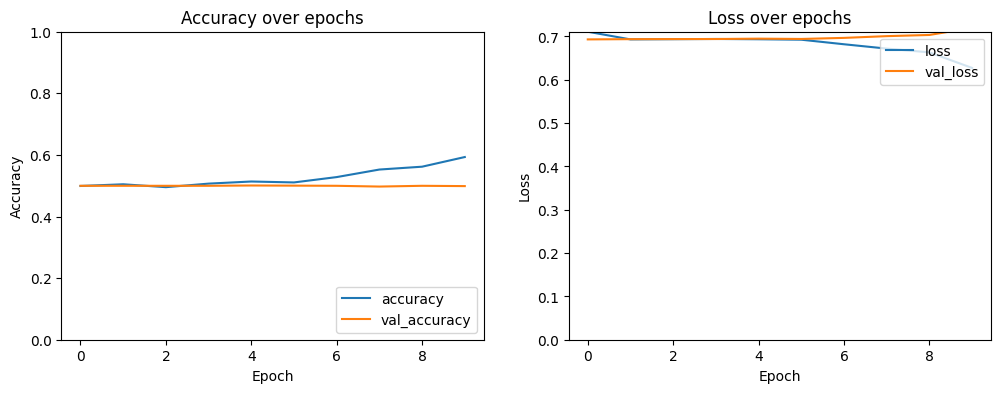

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

# Load datasets
train_ds = image_dataset_from_directory(
    'data/train',
    labels='inferred',
    label_mode='int',  # Use integer labels (0 for cat, 1 for dog)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    'data/validation',
    labels='inferred',
    label_mode='int',  # Use integer labels (0 for cat, 1 for dog)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

def preprocess_image(image, label):
    image = data_augmentation(image)
    image = Rescaling(1./255)(image)  # Normalize pixel values
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

# Prefetch for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two output classes: cat and dog
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Save the model (optional)
model.save('cat_dog_classifier.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc}")

# Prediction function
def classify_image(img_path, model, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)  # Create batch axis

    # Normalize and make prediction
    img_array = Rescaling(1./255)(img_array)
    predictions = model.predict(img_array)
    class_names = ['cat', 'dog']
    predicted_class = np.argmax(predictions[0])
    return f"It's a {class_names[predicted_class]}"

# Example usage
result = classify_image('.jpg', model)
print(result)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Loss over epochs')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
It's a dog


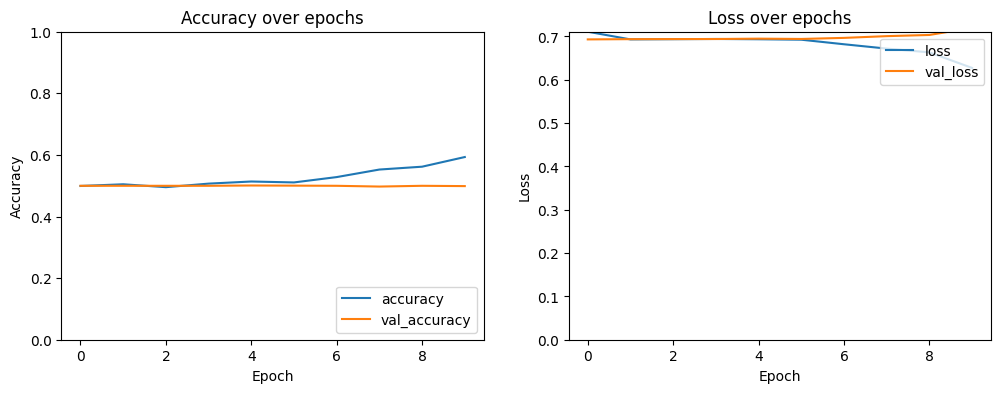

In [3]:
# Example usage
result = classify_image('3.jpg', model)
print(result)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Loss over epochs')

plt.show()